In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Daten einlesen

In [2]:
df = pd.read_pickle("Daten/data.pkl")

# Daten vorverarbeiten

## Features auswählen

In [3]:
df_ohne_id = df.drop(columns=["id"])
# df_ohne_id.drop(columns=["group0__feature_0", "group0__feature_7"], inplace=True)

df_ohne_id.head()

,group0__feature_0,group0__feature_1,group0__feature_2,group0__feature_3,group0__feature_4,group0__feature_5,group0__feature_6,group0__feature_7,group0__feature_8,group0__feature_9,group1__feature_0,group1__feature_1,group1__feature_2,group1__feature_3
0,0.365569,0.324112,0.762024,-0.373122,-1.184416,-0.900508,0.972732,0.310239,-0.953444,-0.059217,-0.348563,-0.960534,-0.562884,-0.130034
1,0.444764,0.471379,-0.085384,-0.373122,-1.398808,0.592319,0.026373,0.480262,-1.108196,-0.059217,-0.541528,0.176524,0.346141,-1.069655
2,0.328415,0.411231,-0.708222,-0.844989,-1.041489,0.592319,-0.139419,0.420130,-1.929925,-0.059217,0.424636,0.077649,0.399618,0.914411
3,0.639342,0.788726,-1.126775,-0.069779,-1.041489,0.253019,0.211661,0.792314,-1.249282,0.888417,1.261821,-1.207720,-1.044139,1.227799
4,0.133842,0.163365,-0.391679,-0.406827,-1.327344,1.203016,0.649325,0.181686,-0.279337,-0.059217,0.746579,-0.812222,-0.348999,-0.025753


In [4]:
df_ohne_id.shape

(32732, 14)

In [5]:
feature_names = df_ohne_id.columns
feature_cnt = df_ohne_id.shape[1]
feature_cnt

14

## Daten aufspalten in Trainings-, Validierungs- und Testdaten

- 60% Trainingsdaten
- 20 % Validierungsdaten
- 20 % Testdaten

In [6]:
random_state = 21

x_train, x_test, y_train, y_test = train_test_split(df_ohne_id, np.zeros(shape=df_ohne_id.shape[0]), test_size=0.2, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=random_state)

del y_train
del y_val
del y_test

x_train.shape, x_val.shape, x_test.shape

((19638, 14), (6547, 14), (6547, 14))

## Daten normalisieren auf 0 bis 1

In [7]:
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

# Modell erstellen

In [8]:
class Autoencoder(Model):
    def __init__(self, feature_cnt):
        super(Autoencoder, self).__init__()
        self.encoder = keras.Sequential([
            layers.Dense(8, activation="relu", name="layer_2"),
            layers.Dense(4, activation="relu", name="layer_3_middle"),
        ], name="encoder")
        self.decoder = keras.Sequential([
            layers.Dense(8, activation="relu", name="layer_4"),
            layers.Dense(feature_cnt, activation="sigmoid", name="layer_5_output"),
        ], name="decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder(feature_cnt=feature_cnt)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])
autoencoder.build(input_shape=(None, feature_cnt))

## Autoencoder Zusammenfassung

In [9]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 4)                 156       
                                                                 
 decoder (Sequential)        (None, 14)                166       
                                                                 
Total params: 322
Trainable params: 322
Non-trainable params: 0
_________________________________________________________________


## Encoder Zusammenfassung

In [10]:
autoencoder.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_2 (Dense)             (None, 8)                 120       
                                                                 
 layer_3_middle (Dense)      (None, 4)                 36        
                                                                 
Total params: 156
Trainable params: 156
Non-trainable params: 0
_________________________________________________________________


## Decoder Zusammenfassung

In [11]:
autoencoder.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_4 (Dense)             (None, 8)                 40        
                                                                 
 layer_5_output (Dense)      (None, 14)                126       
                                                                 
Total params: 166
Trainable params: 166
Non-trainable params: 0
_________________________________________________________________


# Modell trainieren

In [12]:
history = autoencoder.fit(x_train_scaled, x_train_scaled,
                          epochs=20,
                          batch_size=512,
                          validation_data=(x_val_scaled, x_val_scaled),
                          shuffle=True,
                         )

Epoch 1/20
39/39 [==============================] - 1s 6ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 2/20
39/39 [==============================] - 0s 2ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 3/20
39/39 [==============================] - 0s 2ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 4/20
39/39 [==============================] - 0s 2ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 5/20
39/39 [==============================] - 0s 2ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 6/20
39/39 [==============================] - 0s 2ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 7/20
39/39 [==============================] - 0s 2ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 8/20
39/39 [==============================] - 0s 2ms/step - loss: 0.0109 - mse: 0.01

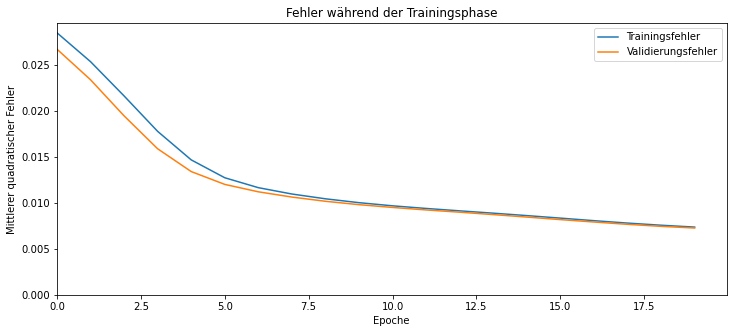

In [13]:
plt.figure(figsize=(12, 5))

plt.plot(history.history["loss"], label="Trainingsfehler")
plt.plot(history.history["val_loss"], label="Validierungsfehler")

plt.legend()
plt.xlabel("Epoche")
plt.ylabel("Mittlerer quadratischer Fehler")
plt.title("Fehler während der Trainingsphase")
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.show()

# Modell für die ersten 5 Bauteile (aus den Testdaten) testen

In [14]:
encoded_data_scaled = autoencoder.encoder(x_test_scaled).numpy()
decoded_data_scaled = autoencoder.decoder(encoded_data_scaled).numpy()

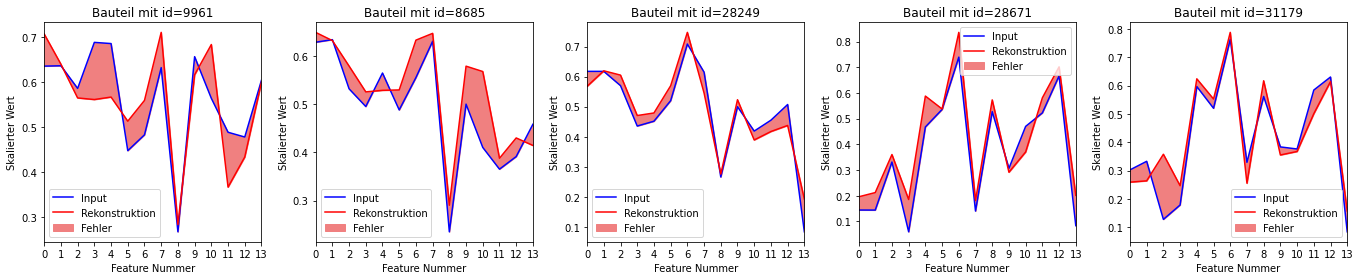

In [15]:
anz_plots = 5

fig, axes = plt.subplots(nrows=1, ncols=anz_plots, figsize=(19, 4))

for i, ax in enumerate(axes.flatten()):
    ax.plot(x_test_scaled[i], 'b', label="Input")
    ax.plot(decoded_data_scaled[i], 'r', label="Rekonstruktion")
    ax.fill_between(np.arange(feature_cnt), decoded_data_scaled[i], x_test_scaled[i], color='lightcoral', label="Fehler")
    ax.set_xticks([x for x in range(feature_cnt)])
    ax.set_xlim(0, feature_cnt - 1)
    ax.legend()
    ax.set_xlabel("Feature Nummer")
    ax.set_ylabel("Skalierter Wert")
    ax.set_title(f"Bauteil mit id={x_test.index[i]}")
    

plt.tight_layout()
plt.show()

# Rekonstruktionsfehler und Threshold für Anomalien berechnen

In [16]:
def rmse(x, y):
    return np.sqrt(((x - y) ** 2).mean(axis=1))

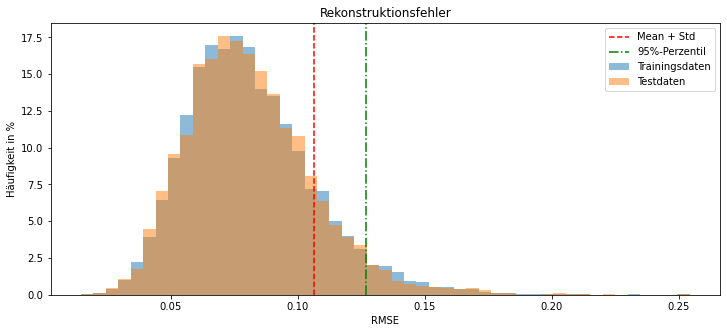

In [17]:
reconstructions = autoencoder.predict(x_train_scaled)
reconstructions_test = autoencoder.predict(x_test_scaled)
reconstruction_errors = rmse(x_train_scaled, reconstructions)
reconstruction_test_errors = rmse(x_test_scaled, reconstructions_test)

threshold_std = np.mean(reconstruction_errors) + np.std(reconstruction_errors)
threshold_95 = np.percentile(reconstruction_errors, 95)

plt.figure(figsize=(12, 5))

value_min = np.min([reconstruction_errors.min(), reconstruction_test_errors.min()])
value_max = np.max([reconstruction_errors.max(), reconstruction_test_errors.max()])
bins = np.linspace(value_min, value_max, 50)

plt.hist(reconstruction_errors, bins=bins, alpha=0.5, density=True, label="Trainingsdaten")
plt.hist(reconstruction_test_errors, bins=bins, alpha=0.5, density=True, label="Testdaten")
plt.axvline(threshold_std, color="r", linestyle="--", label="Mean + Std")
plt.axvline(threshold_95, color="g", linestyle="-.", label="95%-Perzentil")
plt.xlabel("RMSE")
plt.ylabel("Häufigkeit in %")
plt.title("Rekonstruktionsfehler")
plt.legend()

plt.show()

# Rekonstruktionsfehler der Trainingsdaten mit künstlich erzeugten anomalen Daten vergleichen

- Alle Features = 0.5 -> d.h. immer der Mittelwert aus dem kleinsten in den Trainingsdaten gesehen Wert und dem größten
- Zufällige Werte zwischen 0 und 1
- geflippte Testdaten (Vorzeichen vertauscht)

In [18]:
always_05 = np.zeros(feature_cnt).reshape(1, feature_cnt) + 0.5
random_values = np.random.rand(x_test_scaled.shape[0], feature_cnt)
flipped_values = -x_test_scaled

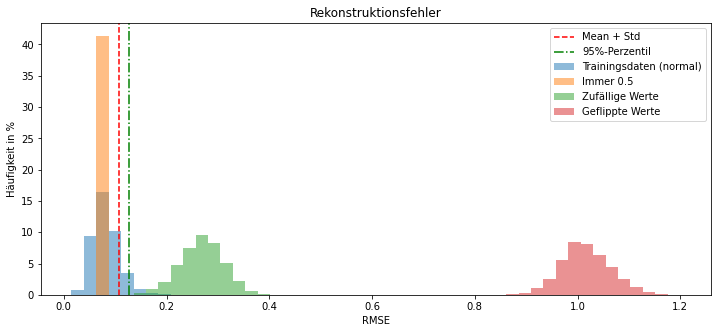

In [22]:
reconstructions = autoencoder.predict(x_train_scaled)
reconstructions_always_05 = autoencoder.predict(always_05)
reconstructions_random_values = autoencoder.predict(random_values)
reconstructions_flipped_values = autoencoder.predict(flipped_values)
reconstruction_errors = rmse(x_train_scaled, reconstructions)
reconstruction_always_05_errors = rmse(always_05, reconstructions_always_05)
reconstruction_random_values_errors = rmse(random_values, reconstructions_random_values)
reconstruction_flipped_values_errors = rmse(flipped_values, reconstructions_flipped_values)

threshold_std = np.mean(reconstruction_errors) + np.std(reconstruction_errors)
threshold_95 = np.percentile(reconstruction_errors, 95)

plt.figure(figsize=(12, 5))

value_min = np.min([reconstruction_errors.min(), reconstruction_always_05_errors.min(), reconstruction_random_values_errors.min(), reconstruction_flipped_values_errors.min()])
value_max = np.max([reconstruction_errors.max(), reconstruction_always_05_errors.max(), reconstruction_random_values_errors.max(), reconstruction_flipped_values_errors.max()])
bins = np.linspace(value_min, value_max, 50)

plt.hist(reconstruction_errors, bins=bins, alpha=0.5, density=True, label="Trainingsdaten (normal)")
plt.hist(reconstruction_always_05_errors, bins=bins, alpha=0.5, density=True, label="Immer 0.5")
plt.hist(reconstruction_random_values_errors, bins=bins, alpha=0.5, density=True, label="Zufällige Werte")
plt.hist(reconstruction_flipped_values_errors, bins=bins, alpha=0.5, density=True, label="Geflippte Werte")
plt.axvline(threshold_std, color="r", linestyle="--", label="Mean + Std")
plt.axvline(threshold_95, color="g", linestyle="-.", label="95%-Perzentil")
plt.xlabel("RMSE")
plt.ylabel("Häufigkeit in %")
plt.title("Rekonstruktionsfehler")
plt.legend()

plt.show()

# Anomalie-Score berechnen

In [ ]:
# TODO: impl (+ evtl. Recherche dazu wie man das macht)

# Modell und Skalierer abspeichern

In [ ]:
filename_model = "autoencoder.tf"
autoencoder.save(filename_model)

filename_scaler = "scaler.tf"
pickle.dump(scaler, open(filename_scaler, "wb"))

In [ ]:
# Model laden:
# autoencoder = tf.keras.models.load_model(filename_model)

# Skalierer laden:
# scaler = pickle.load(open(filename_scaler, "rb"))